## Import libraries and load files

In [0]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [2]:
get_available_gpus()

['/device:GPU:0']

In [0]:
import tensorflow as tf

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import SCORERS

from sklearn.model_selection import KFold
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from warnings import warn

import numpy as np
import pandas as pd
from datetime import datetime

from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, adjusted_rand_score

In [0]:
#Read the data using the Unnamed (probably id) as index
url = 'https://s3.amazonaws.com/drivendata/data/4/public/81e8f2de-9915-4934-b9ae-9705685c9d50.csv'
#url = '../src/data/raw/training.csv'
training = pd.read_csv(url, index_col='Unnamed: 0')

labels = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 
          'Sharing', 'Student_Type', 'Use']

numeric = ['FTE', 'Total']

categoric = [ 'Facility_or_Department', 'Function_Description', 
            'Fund_Description', 'Job_Title_Description', 'Location_Description', 
            'Object_Description', 'Position_Extra', 'Program_Description', 'SubFund_Description', 
            'Sub_Object_Description', 
            'Text_1', 'Text_2', 'Text_3', 'Text_4']

### FunctionTransformers

In [0]:
# Define combine_text_columns()
def combine_text_columns(data_frame):
    """ converts all text in each row of data_frame to single vector """
    
    # Drop non-text columns that are in the df
    text_data = data_frame[categoric].copy()
    
    # Replace nans with blanks
    text_data.fillna("", inplace=True)
    
    for category in categoric:
      training.loc[:,category] = training[category].str.lower()
    
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

In [0]:
groupped_FTE = training[['FTE', 'Object_Type']].groupby(by='Object_Type')
groupped_total = training[['Total', 'Object_Type']].groupby(by='Object_Type')
# Define combine_numeric_columns()
def combine_numeric_columns(data_frame, groupped_FTE=groupped_FTE, groupped_total=groupped_total):
    """ process all the numeric data """
    
    # Drop non-numeric columns that are in the df
    data = data_frame[numeric].copy()
    
    #Remove inconsistent data
    data.loc[(data[numeric[0]] < 0) | (data[numeric[0]] > 1), numeric[0]] = np.nan
    data.loc[(data[numeric[1]] < 0), numeric[1]] = np.nan
    
    #Impute the missing data with the median from each class
    for group in groupped_FTE.median().index:
      indexes_FTE = groupped_FTE.get_group(group).index.values
      indexes_total = groupped_total.get_group(group).index.values
      data.loc[ data.FTE.isnull() & np.isin(data.index.values,indexes_FTE), 'FTE'] = groupped_FTE.median().loc[group, "FTE"]
      data.loc[ data.Total.isnull() & np.isin(data.index.values,indexes_total), 'Total'] = groupped_total.median().loc[group,"Total"]
      
    return data

In [0]:
# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

# Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(combine_numeric_columns, validate=False)

In [0]:
# Recover the targets and split the data
y = pd.get_dummies(training['Object_Type'])

X = training.drop(columns=labels)

# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled = rus.fit_resample(X, y)

### Pipeline

Apply the transformations on numeric and categorica data. Neither dimension reduction or standard scaler are used.

In [0]:
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imp', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer',HashingVectorizer(token_pattern="[A-Za-z0-9]+(?=\\s+)", 
                                                    norm=None, 
                                                    binary=False,
                                                    ngram_range=(1,2)) 
                    )
                ]))
             ]
        )),
        ('reduce_dim', TruncatedSVD(n_components = 100)),
        # ('clf', AgglomerativeClustering(memory='mycachedir', 
        #                     compute_full_tree=True, n_clusters=3))
        
    ])

In [0]:
col_names = list(range(0,11))

In [0]:
y.columns = col_names

In [0]:
labels_true = y.idxmax(axis=1)

Applying the steps, we got a sparse matrix with 1048578 features.

In [0]:
data_X= pl.fit_transform(X, labels_true)

In [0]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(data_X, labels_true)

In [28]:
X_resampled.shape

(35420, 100)

In [29]:
y_resampled.shape

(35420,)

With the purpose of calculating the adjusted rand score, we need to set the labels to numbers between 0 and 10.

## Training
The model is trained and tested using the number of groups varying between 2 and 20. As the agglomerative clustering method is deterministic, the model is fitted only one time.

In [0]:
results = []

In [30]:
for k in range(2, 21):
  agg = AgglomerativeClustering(memory='mycachedir', 
                             compute_full_tree=True, n_clusters=k)
  start = datetime.now()
  with tf.device('/gpu:0'):
    #fit model to data
    cluster_labels = agg.fit_predict(X_resampled)
  
  end = datetime.now()
  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(X_resampled, cluster_labels)
  print("For n_clusters =", k,
        "The average silhouette_score is :", silhouette_avg)
  
  db_avg = davies_bouldin_score(X_resampled, cluster_labels)
  print("The average db_score is :", db_avg)
  
  ars_avg = adjusted_rand_score(y_resampled, cluster_labels)
  print("The average ars_score is :", ars_avg)
  
  
  # Append the results
  results.append({'k':k, 'silhouette': silhouette_avg,
                 'db': db_avg,'time': end-start, 'ars':ars_avg})

For n_clusters = 2 The average silhouette_score is : 0.9973498370915256
The average db_score is : 0.4211945242711094
The average ars_score is : 6.826789991637767e-08


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 3 The average silhouette_score is : 0.9964424674442612
The average db_score is : 0.28115923326168085
The average ars_score is : 5.869728293764621e-08


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 4 The average silhouette_score is : 0.9849724617183053
The average db_score is : 0.4357246758086379
The average ars_score is : 5.364189628559041e-06


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 5 The average silhouette_score is : 0.9794985495571461
The average db_score is : 0.3641012123493891
The average ars_score is : 4.637751608437424e-06


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 6 The average silhouette_score is : 0.9425739600913966
The average db_score is : 0.42960720202325803
The average ars_score is : 3.5984523510150614e-05


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 7 The average silhouette_score is : 0.9425444483970711
The average db_score is : 0.34833445596588203
The average ars_score is : 3.598484757111938e-05


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 8 The average silhouette_score is : 0.8482087265492515
The average db_score is : 0.40799396511072
The average ars_score is : 0.008518353178158803


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 9 The average silhouette_score is : 0.8481915588744184
The average db_score is : 0.3774952012337176
The average ars_score is : 0.008518342418604231


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 10 The average silhouette_score is : 0.8485213011384071
The average db_score is : 0.3670659898316187
The average ars_score is : 0.008517652978329638


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 11 The average silhouette_score is : 0.8485244250920837
The average db_score is : 0.37462622653035815
The average ars_score is : 0.008517647474047901


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 12 The average silhouette_score is : 0.848547318457863
The average db_score is : 0.3757308576169158
The average ars_score is : 0.00851764323470704


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 13 The average silhouette_score is : 0.8591464814408256
The average db_score is : 0.37144624351326133
The average ars_score is : 0.007146449145134277


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 14 The average silhouette_score is : 0.8593726994996256
The average db_score is : 0.3854007402075614
The average ars_score is : 0.007141427501139917


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 15 The average silhouette_score is : 0.8594753918210228
The average db_score is : 0.4045885207246708
The average ars_score is : 0.007140871033413861


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 16 The average silhouette_score is : 0.846053953994106
The average db_score is : 0.4056957813153646
The average ars_score is : 0.006056527893821542


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 17 The average silhouette_score is : 0.846048453496104
The average db_score is : 0.39795821139614657
The average ars_score is : 0.006056520626419885


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 18 The average silhouette_score is : 0.8460472089288835
The average db_score is : 0.40332733625182865
The average ars_score is : 0.006056488164145407


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 19 The average silhouette_score is : 0.8460969288020156
The average db_score is : 0.4116977425946152
The average ars_score is : 0.006056434919371806


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


For n_clusters = 20 The average silhouette_score is : 0.8466226999056143
The average db_score is : 0.4169241235310883
The average ars_score is : 0.005987016830860013


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [31]:
len(results)

19

In [0]:
results_df = pd.DataFrame(results)

In [33]:
results_df.head()

,ars,db,k,silhouette,time
0,6.826790e-08,0.421195,2,0.997350,00:01:53.251386
1,5.869728e-08,0.281159,3,0.996442,00:00:00.120037
2,5.364190e-06,0.435725,4,0.984972,00:00:00.112248
3,4.637752e-06,0.364101,5,0.979499,00:00:00.114934
4,3.598452e-05,0.429607,6,0.942574,00:00:00.110663


In [0]:
results_df['seconds'] = results_df.time.apply(lambda x: x.total_seconds() )

In [35]:
results_df.head()

,ars,db,k,silhouette,time,seconds
0,6.826790e-08,0.421195,2,0.997350,00:01:53.251386,113.251386
1,5.869728e-08,0.281159,3,0.996442,00:00:00.120037,0.120037
2,5.364190e-06,0.435725,4,0.984972,00:00:00.112248,0.112248
3,4.637752e-06,0.364101,5,0.979499,00:00:00.114934,0.114934
4,3.598452e-05,0.429607,6,0.942574,00:00:00.110663,0.110663


In [0]:
import seaborn as sns

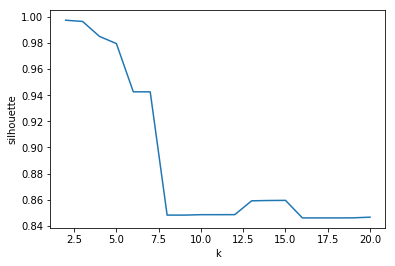

In [37]:
sns.lineplot(results_df.k, results_df.silhouette)

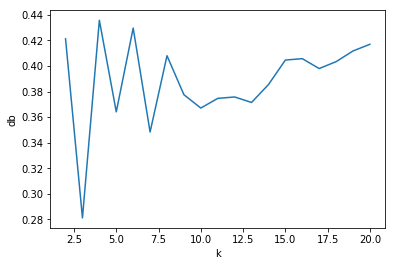

In [38]:
ax = sns.lineplot("k", "db", data=results_df,markers=True)

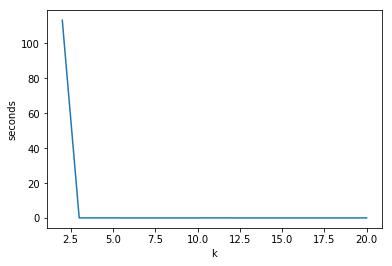

In [39]:
ax = sns.lineplot("k", "seconds", data=results_df)

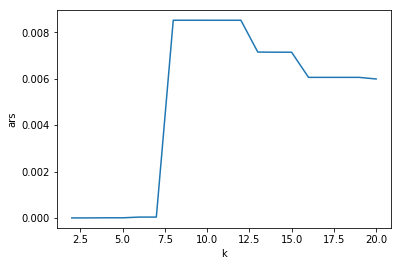

In [40]:
ax = sns.lineplot("k", "ars", data=results_df)

In [0]:
results_df.to_csv('agg_clustering.csv')